In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"joelbasilkurian","key":"fff447dabe5eddf0c64a6bd88681cc14"}'}

In [ ]:
import os
import zipfile

# Create kaggle directory
os.makedirs('/root/.kaggle', exist_ok=True)

# Move kaggle.json into it
!mv kaggle.json /root/.kaggle/

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d giovamata/airlinedelaycauses

Dataset URL: https://www.kaggle.com/datasets/giovamata/airlinedelaycauses
License(s): unknown
  0% 0.00/66.6M [00:00<?, ?B/s]
100% 66.6M/66.6M [00:00<00:00, 1.71GB/s]


In [ ]:
with zipfile.ZipFile("airlinedelaycauses.zip", 'r') as zip_ref:
    zip_ref.extractall("airlinedelaycauses")

In [ ]:
print("--- Step 1: Loading BTS and NTSB Data ---")

try:
    # Load the NTSB dataset using the robust 'cp1252' encoding
    ntsb_df = pd.read_csv('ntsb.csv', low_memory=False, encoding='cp1252')
    # Load the BTS dataset
    bts_df = pd.read_csv('/content/airlinedelaycauses/DelayedFlights.csv', low_memory=False)

    print("Data loaded successfully.")

except FileNotFoundError as e:
    print(f"File not found: {e}. Please ensure both 'ntsb.csv' and 'bts.csv' are uploaded.")

--- Step 1: Loading BTS and NTSB Data ---
Data loaded successfully.


In [ ]:
print("\n--- Cleaning BTS Data ---")
if 'Unnamed: 0' in bts_df.columns:
    bts_df.drop(columns=['Unnamed: 0'], inplace=True)

bts_df.dropna(subset=['TailNum', 'DepTime', 'ArrTime', 'ActualElapsedTime'], inplace=True)
bts_df = bts_df[(bts_df['Cancelled'] == 0) & (bts_df['Diverted'] == 0)]
bts_df['FlightDate'] = pd.to_datetime(bts_df[['Year', 'Month', 'DayofMonth']].rename(columns={'Year': 'year', 'Month': 'month', 'DayofMonth': 'day'}))
bts_df['TailNum'] = bts_df['TailNum'].str.strip().str.upper()

bts_clean = bts_df[[
    'FlightDate', 'TailNum', 'UniqueCarrier', 'FlightNum',
    'Origin', 'Dest', 'DepTime', 'ArrTime',
    'DepDelay', 'ArrDelay', 'Distance', 'AirTime'
]].copy()
print(f"Cleaned BTS data shape: {bts_clean.shape}")


--- Cleaning BTS Data ---
Cleaned BTS data shape: (1928368, 12)


In [ ]:
print("\n--- Cleaning NTSB Data (Removing Leaky Features) ---")

# Replace dots in column names
ntsb_df.columns = ntsb_df.columns.str.replace('.', '_', regex=False)

# Convert the 'Event_Date' column to datetime
ntsb_df['Event_Date'] = pd.to_datetime(ntsb_df['Event_Date'], errors='coerce')
ntsb_df.dropna(subset=['Event_Date', 'Registration_Number'], inplace=True)

# Standardize the 'Registration_Number' column
ntsb_df['Registration_Number'] = ntsb_df['Registration_Number'].str.strip().str.upper()

# Select ONLY the key columns. DO NOT include phase of flight, damage, etc.
ntsb_clean = ntsb_df[['Event_Date', 'Registration_Number']].copy()

# Rename the key columns to match the BTS dataframe
ntsb_clean.rename(columns={
    'Event_Date': 'FlightDate',
    'Registration_Number': 'TailNum'
}, inplace=True)

# Remove duplicates to ensure we only label each flight once
ntsb_clean = ntsb_clean.drop_duplicates(subset=['FlightDate', 'TailNum'])

print(f"Cleaned NTSB data shape: {ntsb_clean.shape}")


--- Cleaning NTSB Data (Removing Leaky Features) ---
Cleaned NTSB data shape: (87442, 2)


In [ ]:
print("\n--- Step 3: Merging Datasets and Labeling (Corrected) ---")
# Start with the clean BTS data
master_df = bts_clean.copy()

# Create a unique key for matching
ntsb_clean['incident_key'] = ntsb_clean['FlightDate'].astype(str) + '-' + ntsb_clean['TailNum']
master_df['flight_key'] = master_df['FlightDate'].astype(str) + '-' + master_df['TailNum']

# Initialize target variable
master_df['Incident_Occurred'] = 0

# Find flights that match an incident key and set their flag to 1
master_df.loc[master_df['flight_key'].isin(ntsb_clean['incident_key']), 'Incident_Occurred'] = 1
print(f"Total incidents labeled in master dataset: {master_df['Incident_Occurred'].sum()}")

# Drop helper columns
master_df.drop(columns=['flight_key'], inplace=True)
print("Merge complete. No leaky features were added.")


--- Step 3: Merging Datasets and Labeling (Corrected) ---
Total incidents labeled in master dataset: 28
Merge complete. No leaky features were added.



--- Generating Visualizations ---


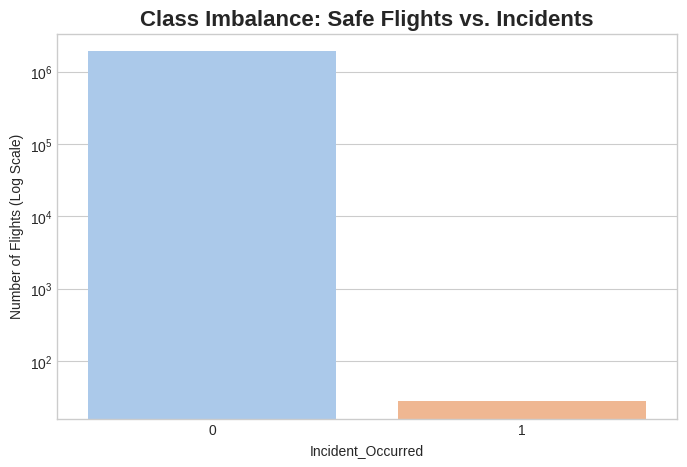

In [ ]:
print("\n--- Generating Visualizations ---")
plt.style.use('seaborn-v0_8-whitegrid')

# Class Imbalance
plt.figure(figsize=(8, 5))
sns.countplot(x='Incident_Occurred', data=master_df, palette='pastel', hue='Incident_Occurred', legend=False)
plt.title('Class Imbalance: Safe Flights vs. Incidents', fontsize=16, fontweight='bold')
plt.ylabel('Number of Flights (Log Scale)')
plt.yscale('log')
plt.show()

In [ ]:
print("\n--- Final Preparation for Machine Learning Model ---")

# Drop identifiers and columns with too much free text or redundancy
# The leaky features are no longer here, so no need to drop them
final_df = master_df.drop(columns=['FlightDate', 'TailNum', 'FlightNum', 'ArrTime', 'DepTime'])

# --- Reduce Cardinality for 'Origin' and 'Dest' ---
print("Reducing cardinality for Origin and Dest...")
N_TOP_AIRPORTS = 50
top_origin_airports = final_df['Origin'].value_counts().nlargest(N_TOP_AIRPORTS).index
final_df['Origin'] = final_df['Origin'].apply(lambda x: x if x in top_origin_airports else 'Other')

top_dest_airports = final_df['Dest'].value_counts().nlargest(N_TOP_AIRPORTS).index
final_df['Dest'] = final_df['Dest'].apply(lambda x: x if x in top_dest_airports else 'Other')
print("Cardinality reduction complete.")

# --- One-Hot Encode categorical features ---
print("Performing one-hot encoding...")
categorical_cols = final_df.select_dtypes(include=['object', 'category']).columns
final_df_encoded = pd.get_dummies(final_df, columns=categorical_cols, drop_first=True, dtype=int)

print("Shape of the final, encoded dataframe:", final_df_encoded.shape)


--- Final Preparation for Machine Learning Model ---
Reducing cardinality for Origin and Dest...
Cardinality reduction complete.
Performing one-hot encoding...
Shape of the final, encoded dataframe: (1928368, 124)


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score, precision_recall_curve, auc
from scipy.stats import uniform, randint

In [ ]:
# Define your features (X) and target (y)
X = final_df_encoded.drop('Incident_Occurred', axis=1)
y = final_df_encoded['Incident_Occurred']

In [ ]:
N_SPLITS = 5  # Use 5 folds for a good balance
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# Lists to store the scores from each fold
fold_recall_scores = []
fold_precision_scores = []
fold_f1_scores = []

print(f"Starting {N_SPLITS}-Fold Stratified Cross-Validation...")

Starting 5-Fold Stratified Cross-Validation...


In [ ]:
fold_counter = 1
for train_index, test_index in skf.split(X, y):
    print(f"\n--- Fold {fold_counter}/{N_SPLITS} ---")

    # 1. Split data for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # 2. Calculate scale_pos_weight for this fold
    #    (We are NO LONGER USING SMOTE)
    count_safe = y_train.value_counts()[0]
    count_incident = y_train.value_counts()[1]
    scale_pos_weight = count_safe / count_incident
    print(f"Training data: {y_train.value_counts().to_dict()}")
    print(f"Using scale_pos_weight: {scale_pos_weight:.2f}")

    # 3. Initialize the XGBoost model with scale_pos_weight
    xgb_classifier = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='aucpr',
        scale_pos_weight=scale_pos_weight,  # <-- THIS IS THE FIX
        n_estimators=1000,
        max_depth=5,
        learning_rate=0.1,
        use_label_encoder=False,
        random_state=42,
        early_stopping_rounds=50
    )

    # 4. Train the model on the ORIGINAL training data
    xgb_classifier.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )

    # 5. Evaluate on the original test set
    y_pred = xgb_classifier.predict(X_test)

    # Calculate and store metrics for the 'Incident (1)' class
    # Use zero_division=0 to prevent errors if a fold has 0 predictions
    recall = recall_score(y_test, y_pred, zero_division=0)
    precision = precision_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    fold_recall_scores.append(recall)
    fold_precision_scores.append(precision)
    fold_f1_scores.append(f1)

    print(f"Fold {fold_counter} Recall: {recall:.4f}")
    print(f"Fold {fold_counter} Precision: {precision:.4f}")
    print(f"Fold {fold_counter} F1-Score: {f1:.4f}")

    fold_counter += 1


--- Fold 1/5 ---
Training data: {0: 1542672, 1: 22}
Using scale_pos_weight: 70121.45


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [05:17:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Fold 1 Recall: 0.1667
Fold 1 Precision: 0.0009
Fold 1 F1-Score: 0.0018

--- Fold 2/5 ---
Training data: {0: 1542672, 1: 22}
Using scale_pos_weight: 70121.45


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [05:18:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Fold 2 Recall: 0.3333
Fold 2 Precision: 0.0003
Fold 2 F1-Score: 0.0006

--- Fold 3/5 ---
Training data: {0: 1542672, 1: 22}
Using scale_pos_weight: 70121.45


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [05:19:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Fold 3 Recall: 0.3333
Fold 3 Precision: 0.0026
Fold 3 F1-Score: 0.0051

--- Fold 4/5 ---
Training data: {0: 1542672, 1: 23}
Using scale_pos_weight: 67072.70


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [05:20:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Fold 4 Recall: 0.4000
Fold 4 Precision: 0.0001
Fold 4 F1-Score: 0.0003

--- Fold 5/5 ---
Training data: {0: 1542672, 1: 23}
Using scale_pos_weight: 67072.70


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [05:21:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Fold 5 Recall: 0.2000
Fold 5 Precision: 0.0006
Fold 5 F1-Score: 0.0012


In [ ]:
print("\n--- Cross-Validation Summary ---")
print(f"Average Recall:    {np.mean(fold_recall_scores):.4f} +/- {np.std(fold_recall_scores):.4f}")
print(f"Average Precision: {np.mean(fold_precision_scores):.4f} +/- {np.std(fold_precision_scores):.4f}")
print(f"Average F1-Score:  {np.mean(fold_f1_scores):.4f} +/- {np.std(fold_f1_scores):.4f}")


--- Cross-Validation Summary ---
Average Recall:    0.2867 +/- 0.0884
Average Precision: 0.0009 +/- 0.0009
Average F1-Score:  0.0018 +/- 0.0017
